In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection
import re
import random

from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp
import scipy.sparse.linalg as spla

plt.rcParams.update({'font.size': 14})

Natoms = 7
DIM    = 2

In [5]:
def read_txt_file(fname):
    data = []
    with open(fname, "r") as f:
        for line in f:
            line = line.strip()
            line = line.strip(" \\n")
            # insert spaces before patterns like "-1." stuck to previous number
            line = re.sub(r"(-[0-9]+\.)", r" \1", line)
            values = [float(value) for value in line.split()]
            data.append(values)
    data = np.array(data)
    print("Raw data shape from file:", data.shape)
    return data

In [6]:
def Dist_Sq_Matrix(x):
    Na = x.shape[1]
    D2 = np.zeros((Na, Na))
    for j in range(Na):
        D2[j, :] = (x[0, :] - x[0, j])**2 + (x[1, :] - x[1, j])**2
    return D2

In [7]:
def sort_coord_num(x):
    x_mat = np.reshape(x, (DIM, Natoms))  # 2-by-7
    Na = Natoms
    D2 = Dist_Sq_Matrix(x_mat)
    coord_num = np.zeros((Na,))
    for j in range(Na):
        ind = np.setdiff1d(range(Na), np.array([j]))
        aux = (D2[j, ind] / 2.25)**4  # 2.25 = 1.5^2
        coord_num[j] = np.sum((1.0 - aux) / (1.0 - aux**2))
    return np.sort(coord_num)

In [8]:
def LJ_energy(xy):
    x_mat = np.reshape(xy, (DIM, Natoms))
    D2 = Dist_Sq_Matrix(x_mat)
    LJ = 0.0
    for i in range(1, Natoms):
        for j in range(i):
            # Note: uses D2**(-12) and D2**(-6) exactly as in the course notebook
            LJ += D2[i, j]**(-12) - D2[i, j]**(-6)
    LJ = 4.0 * LJ
    return LJ

In [13]:
def diffusion_map_knn(features, k=128, eps=1.0, alpha=1.0, n_eigs=10):
    X = features
    N, d = X.shape

    # 1. k-NN based distances
    nbrs = NearestNeighbors(n_neighbors=k, algorithm="auto").fit(X)
    distances, indices = nbrs.kneighbors(X)
    D2 = distances**2

    # Gaussian kernel with standard DM scaling exp(-||x - y||^2 / (4 eps))
    K_data = np.exp(-D2 / (4.0 * eps))

    row_idx = np.repeat(np.arange(N), k)
    col_idx = indices.ravel()
    val = K_data.ravel()
    K = sp.csr_matrix((val, (row_idx, col_idx)), shape=(N, N))

    # symmetrize: K <- (K + K^T)/2
    K = 0.5 * (K + K.T)

    # 2. density q_i = sum_j K_ij
    q = np.array(K.sum(axis=1)).ravel()
    q[q == 0.0] = np.finfo(float).eps

    # 3. anisotropic kernel: K_alpha(i,j) = K_ij / (q_i^α q_j^α)
    q_alpha = q**alpha
    inv_q_alpha = 1.0 / q_alpha
    D_left  = sp.diags(inv_q_alpha, 0)
    D_right = sp.diags(inv_q_alpha, 0)
    K_alpha = D_left @ K @ D_right

    # 4. row-normalize to get Markov matrix P
    d_alpha = np.array(K_alpha.sum(axis=1)).ravel()
    d_alpha[d_alpha == 0.0] = np.finfo(float).eps
    D_inv = sp.diags(1.0 / d_alpha, 0)
    P = D_inv @ K_alpha

    # 5. eigen-decomposition of P^T
    # Looking for largest eigenvalues (magnitude)
    w, v = spla.eigs(P.T, k=n_eigs, which="LR")
    w = w.real
    v = v.real

    # sort by |λ| descending
    idx = np.argsort(-np.abs(w))
    w = w[idx]
    v = v[:, idx]

    # normalize eigenvectors
    for j in range(n_eigs):
        norm = np.linalg.norm(v[:, j])
        if norm > 0:
            v[:, j] /= norm

    return w, v

In [9]:
fname = "LJ7bins_confs.txt"
data_bins = read_txt_file(fname)  # shape (N_raw, 14)

N_raw, d = data_bins.shape
print("Total configurations (raw):", N_raw)

Raw data shape from file: (16641, 14)
Total configurations (raw): 16641


In [10]:
Ikeep = np.zeros((N_raw,))
for j in range(N_raw):
    x = data_bins[j, :]
    if np.sum(x**2) > 1e-10:
        Ikeep[j] = 1

idx_keep = np.argwhere(Ikeep == 1).ravel()
data_aux = data_bins[idx_keep, :]
N_aux, d = data_aux.shape
print("After removing zero configurations:", data_aux.shape)

After removing zero configurations: (10071, 14)


In [11]:
N_sub = min(5000, N_aux)
perm = np.random.permutation(N_aux)
data = data_aux[perm[:N_sub], :]   # shape (N_sub, 14)
N, d = data.shape
print("Using subsampled dataset:", data.shape)

Using subsampled dataset: (5000, 14)


Feature matrix shape: (5000, 7)
Energy vector shape: (5000,)


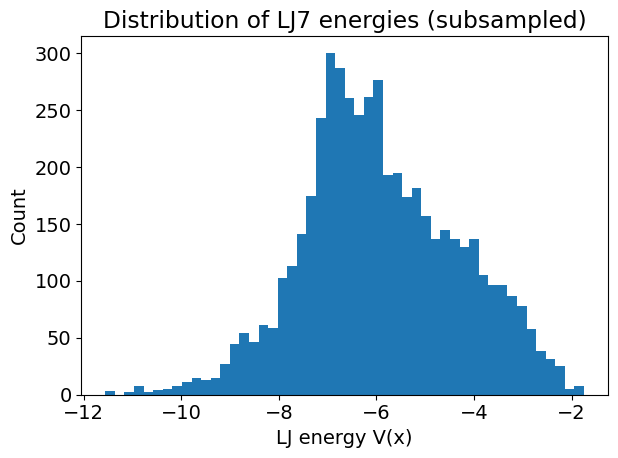

In [ ]:
features = np.zeros((N, Natoms))  # φ(x) in R^7
energies = np.zeros(N)

for i in range(N):
    xy = data[i, :]
    features[i, :] = sort_coord_num(xy)
    energies[i]    = LJ_energy(xy)

print("Feature matrix shape:", features.shape)
print("Energy vector shape:", energies.shape)

plt.figure()
plt.hist(energies, bins=50)
plt.xlabel("LJ energy V(x)")
plt.ylabel("Count")
plt.title("Distribution of LJ7 energies (subsampled)")
plt.tight_layout()
plt.show()

In [14]:
k_example = 128
eps_example = 1.0
alpha = 1.0

lambdas, psi = diffusion_map_knn(features, k=k_example, eps=eps_example,
                                 alpha=alpha, n_eigs=6)

print("Top eigenvalues for k={}, eps={}:".format(k_example, eps_example))
print(lambdas[:6])

Top eigenvalues for k=128, eps=1.0:
[1.         0.99217798 0.98605049 0.97529937 0.96941253 0.95767028]


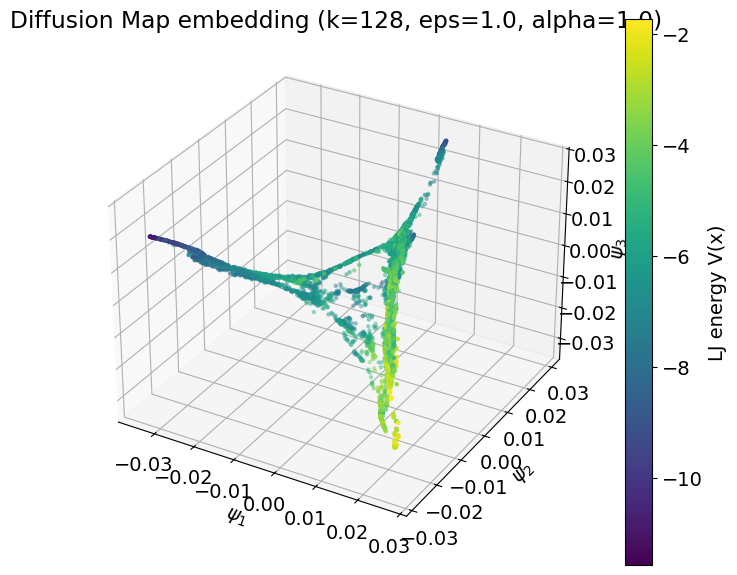

In [15]:
phi1 = psi[:, 1]
phi2 = psi[:, 2]
phi3 = psi[:, 3]

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(phi1, phi2, phi3, c=energies, s=5, cmap='viridis')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_2$')
ax.set_zlabel(r'$\psi_3$')
cbar = fig.colorbar(p, ax=ax)
cbar.set_label("LJ energy V(x)")
ax.set_title(f"Diffusion Map embedding (k={k_example}, eps={eps_example}, alpha={alpha})")
plt.tight_layout()
plt.show()


Computing diffusion map for k=128, eps=0.5 ...


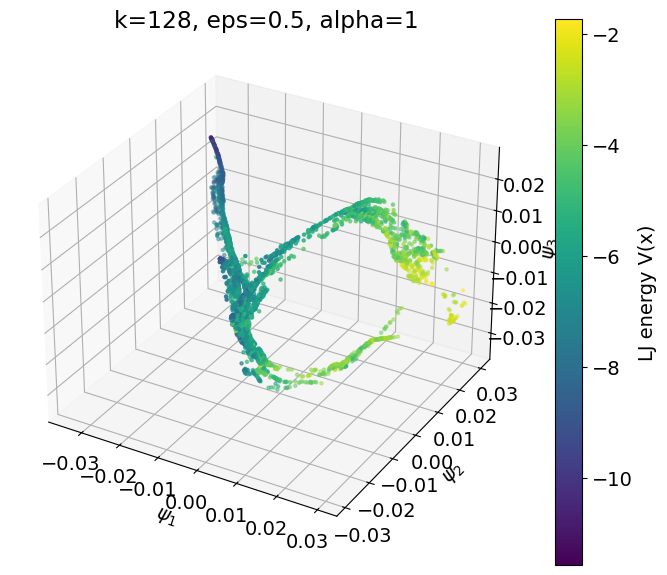


Computing diffusion map for k=128, eps=1.0 ...


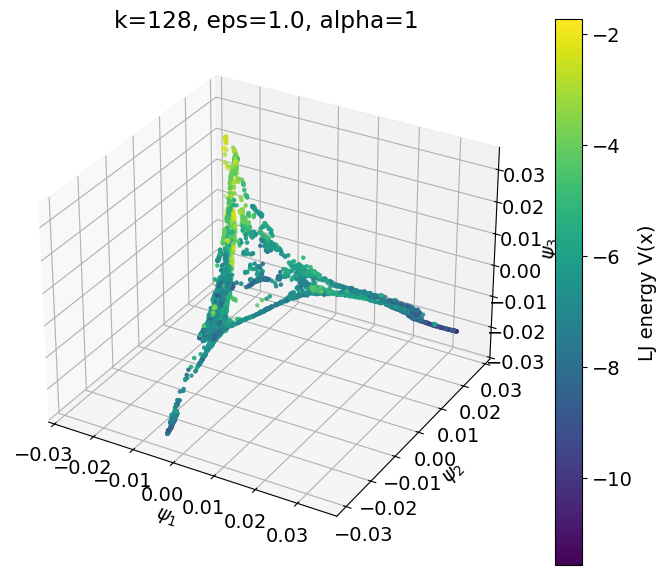


Computing diffusion map for k=128, eps=1.5 ...


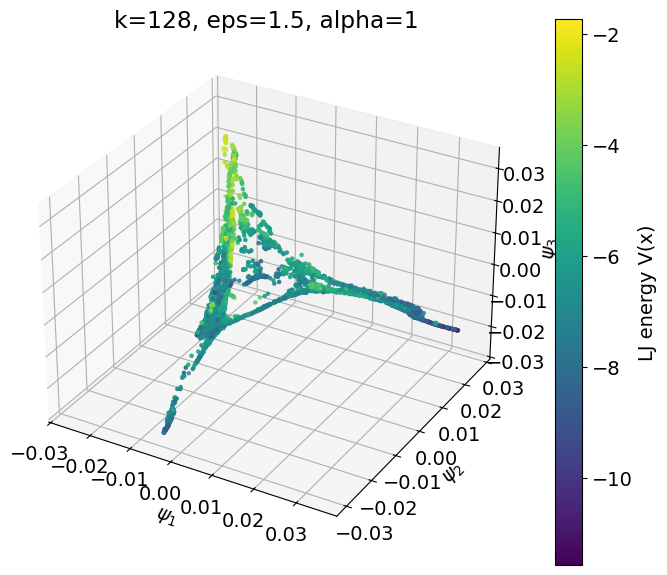


Computing diffusion map for k=128, eps=2.0 ...


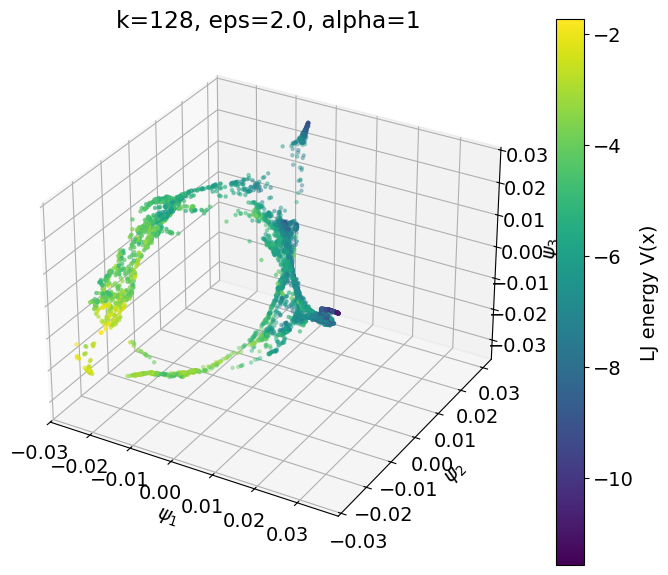


Computing diffusion map for k=256, eps=0.5 ...


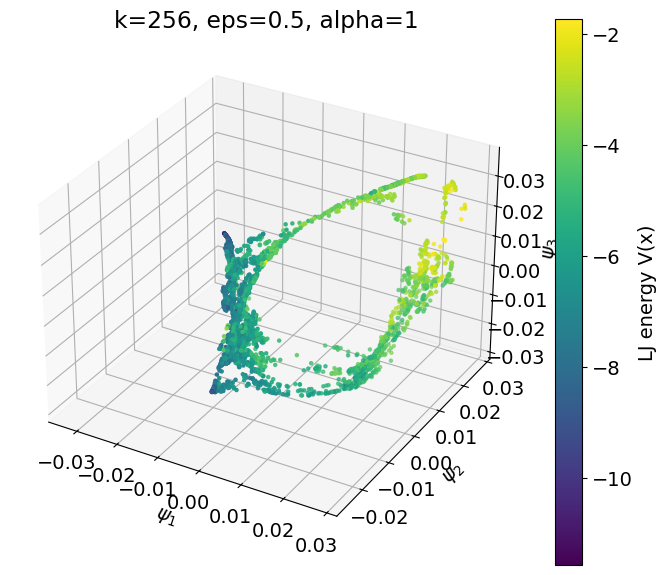


Computing diffusion map for k=256, eps=1.0 ...


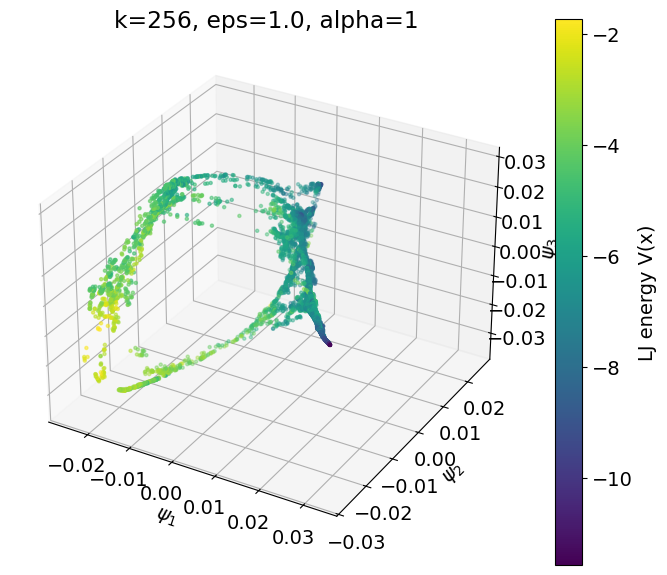


Computing diffusion map for k=256, eps=1.5 ...


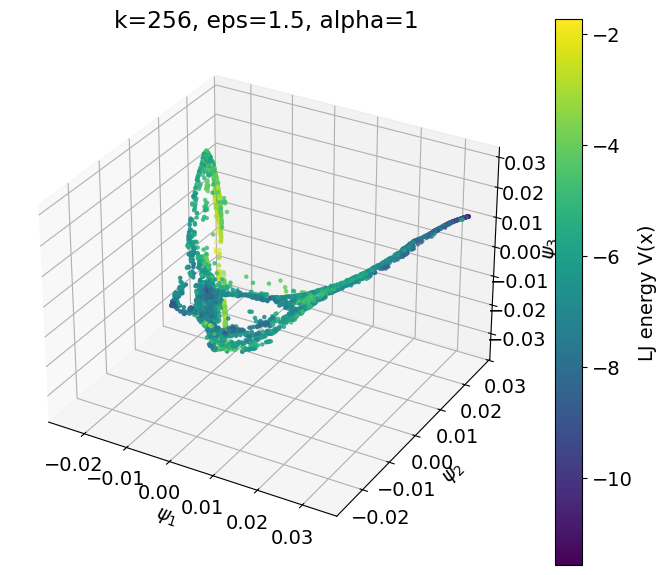


Computing diffusion map for k=256, eps=2.0 ...


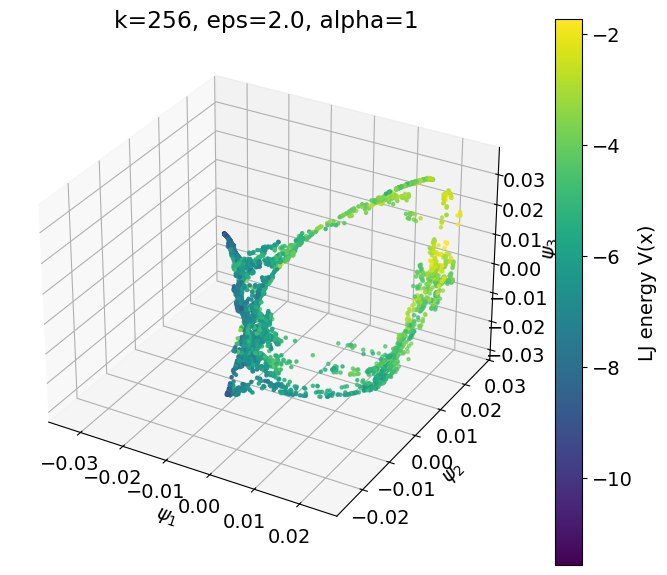


Computing diffusion map for k=512, eps=0.5 ...


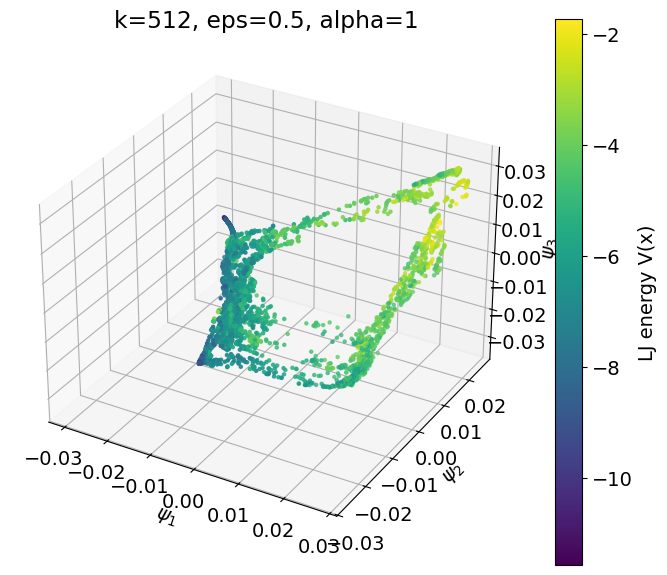


Computing diffusion map for k=512, eps=1.0 ...


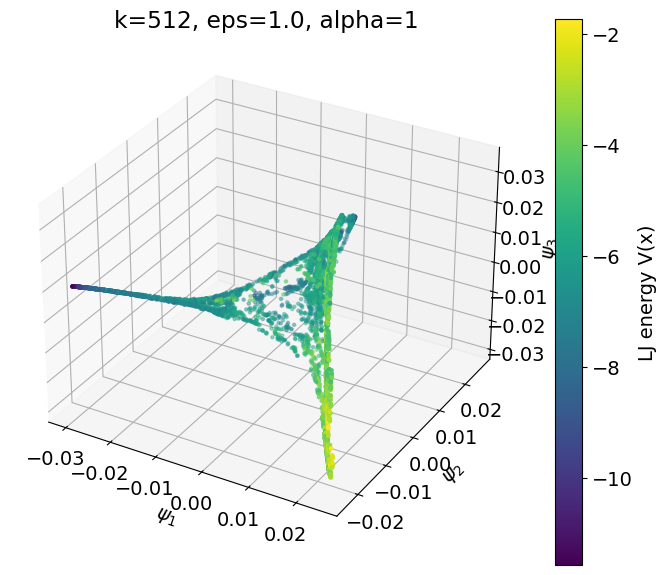


Computing diffusion map for k=512, eps=1.5 ...


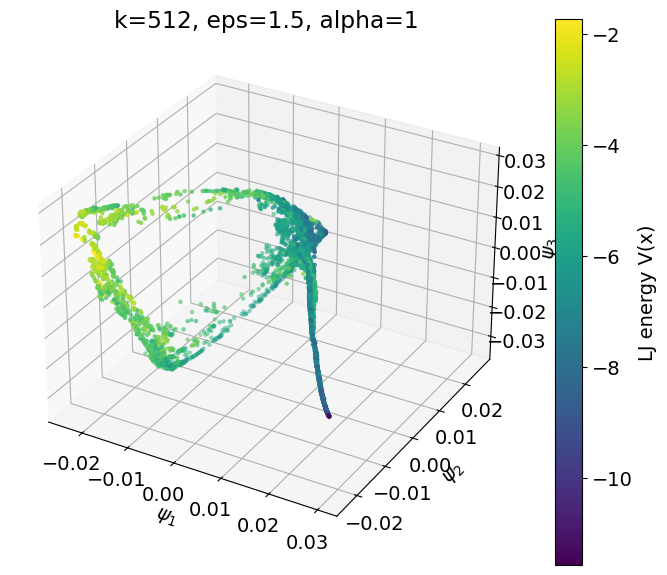


Computing diffusion map for k=512, eps=2.0 ...


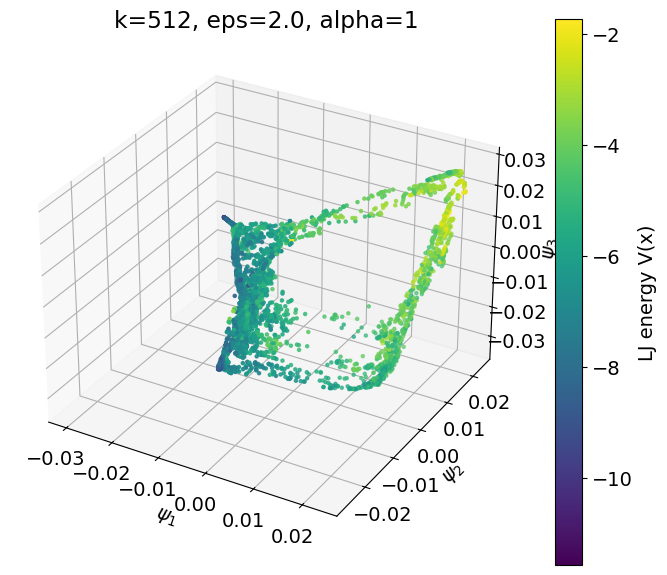


Computing diffusion map for k=1024, eps=0.5 ...


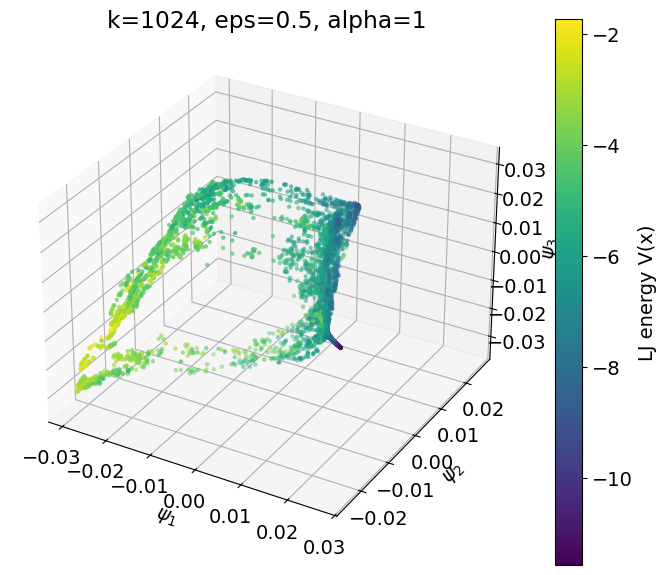


Computing diffusion map for k=1024, eps=1.0 ...


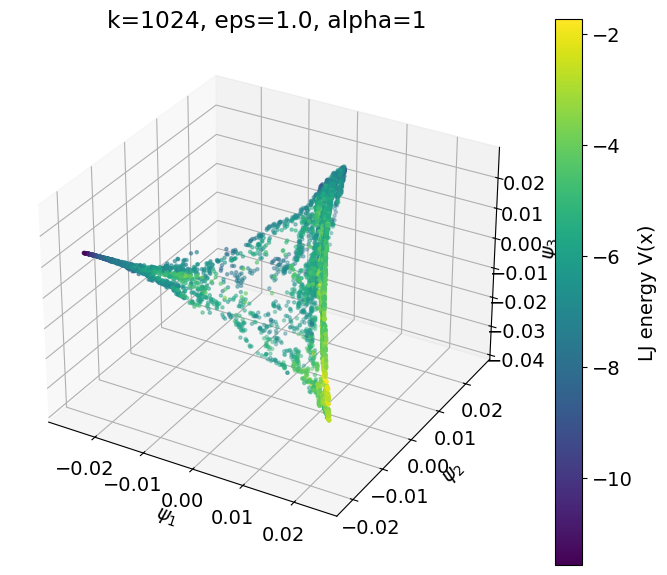


Computing diffusion map for k=1024, eps=1.5 ...


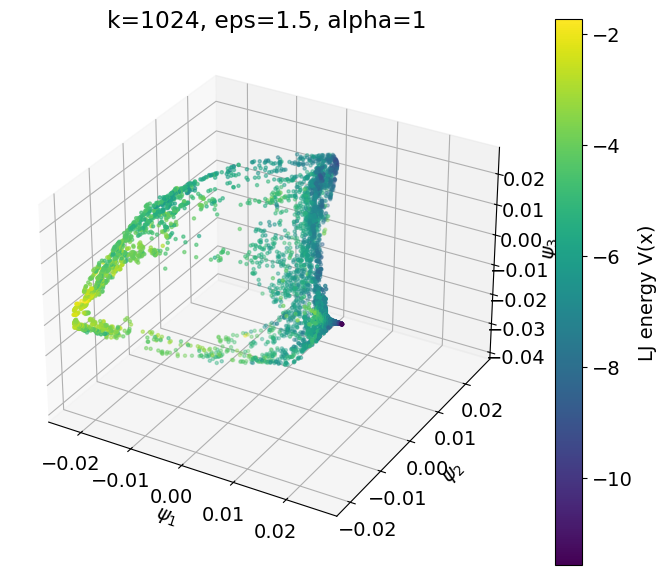


Computing diffusion map for k=1024, eps=2.0 ...


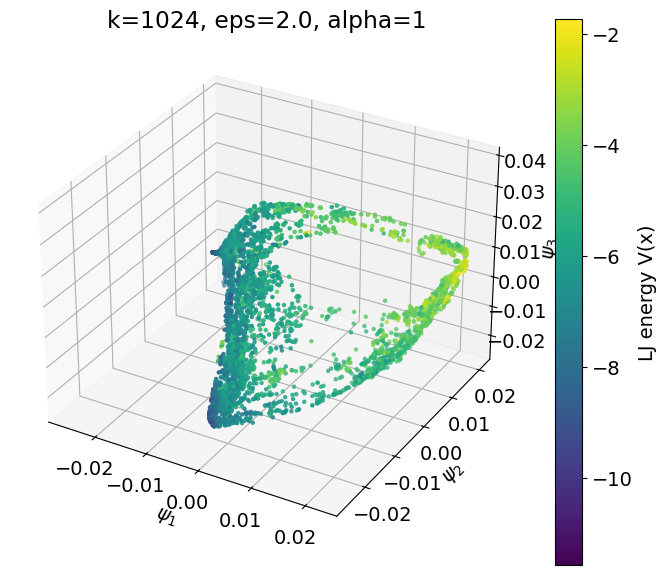


Computing diffusion map for k=2048, eps=0.5 ...


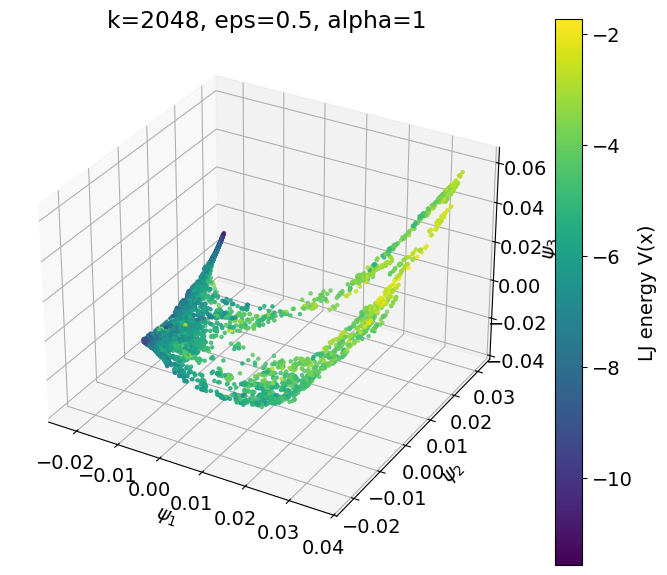


Computing diffusion map for k=2048, eps=1.0 ...


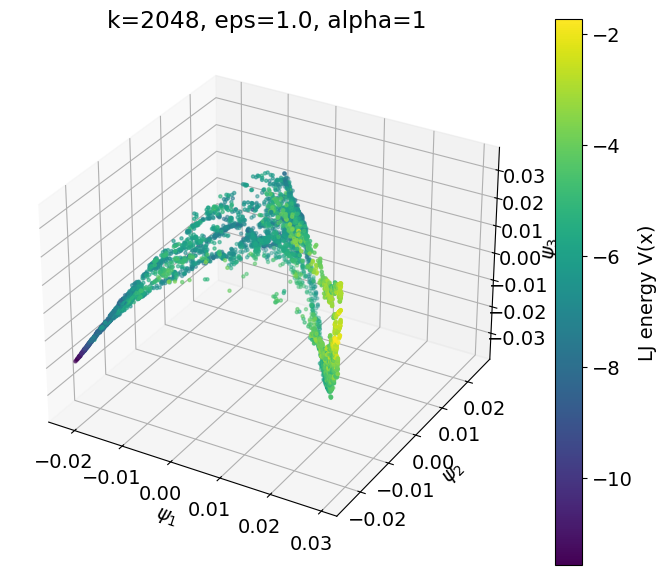


Computing diffusion map for k=2048, eps=1.5 ...


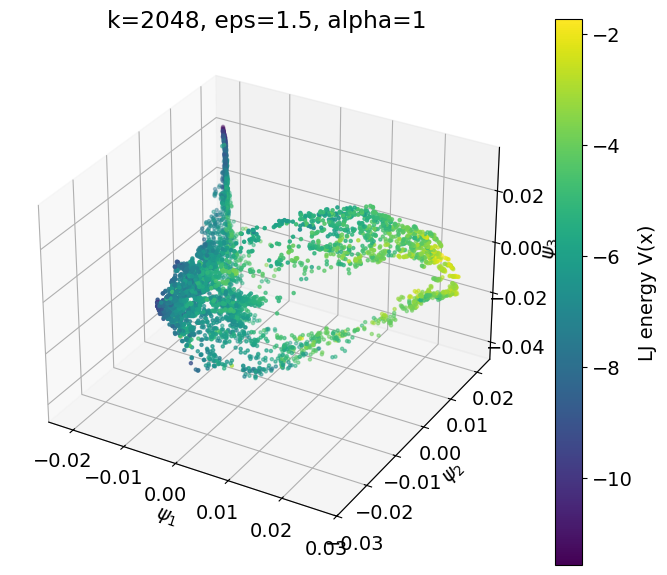


Computing diffusion map for k=2048, eps=2.0 ...


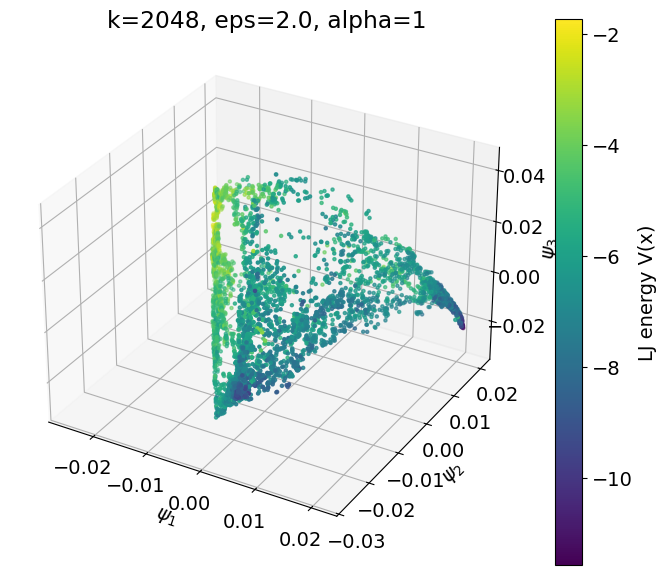

In [16]:
k_list  = [2**p for p in range(7, 12)]   # 128, 256, 512, 1024, 2048
eps_list = [0.5, 1.0, 1.5, 2.0]

for k in k_list:
    for eps in eps_list:
        print(f"\nComputing diffusion map for k={k}, eps={eps} ...")
        lambdas, psi = diffusion_map_knn(features, k=k, eps=eps,
                                         alpha=1.0, n_eigs=6)

        phi1 = psi[:, 1]
        phi2 = psi[:, 2]
        phi3 = psi[:, 3]

        fig = plt.figure(figsize=(7, 6))
        ax = fig.add_subplot(111, projection='3d')
        p = ax.scatter(phi1, phi2, phi3, c=energies, s=5, cmap='viridis')
        ax.set_xlabel(r'$\psi_1$')
        ax.set_ylabel(r'$\psi_2$')
        ax.set_zlabel(r'$\psi_3$')
        cbar = fig.colorbar(p, ax=ax)
        cbar.set_label("LJ energy V(x)")
        ax.set_title(f"k={k}, eps={eps}, alpha=1")
        plt.tight_layout()
        plt.show()